In [1]:
%matplotlib inline
import pickle as pk
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data
file_path = Path("Resources/final_pickle.pkl")
df = pd.read_pickle(file_path)
df = df.drop(columns=["county_code", "census_tract_number", "property_type"])
df.head()

,agency_code,loan_type,owner_occupancy,loan_amount_000s,preapproval,msamd,applicant_ethnicity,co_applicant_ethnicity,applicant_race_1,co_applicant_race_1,...,co_applicant_sex,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,action_taken_summary,Region
0,CFPB,FHA-Insured,Owner Occupied,92.0,Preapproval Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,Black or African American,No Co-Applicant,...,No Co-Applicant,29.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
1,HUD,VA-Guaranteed,Owner Occupied,94.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,No Co-Applicant,...,No Co-Applicant,53.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
2,HUD,FHA-Insured,Owner Occupied,147.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,Not Hispanic or Latino,White,White,...,Female,90.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
3,HUD,FHA-Insured,Owner Occupied,115.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,No Co-Applicant,...,No Co-Applicant,30.0,1948.0,12.58,59700.0,122.93,507.0,724.0,0,SE
4,HUD,VA-Guaranteed,Owner Occupied,160.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,No Co-Applicant,...,No Co-Applicant,50.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE


In [3]:
df.columns

Index(['agency_code', 'loan_type', 'owner_occupancy', 'loan_amount_000s',
       'preapproval', 'msamd', 'applicant_ethnicity', 'co_applicant_ethnicity',
       'applicant_race_1', 'co_applicant_race_1', 'applicant_sex',
       'co_applicant_sex', 'applicant_income_000s', 'population',
       'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'action_taken_summary', 'Region'],
      dtype='object')

In [4]:
# Generate our categorical variable lists
action_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df[action_cat].nunique()

agency_code               6
loan_type                 4
owner_occupancy           2
preapproval               2
applicant_ethnicity       2
co_applicant_ethnicity    3
applicant_race_1          6
co_applicant_race_1       7
applicant_sex             2
co_applicant_sex          3
Region                    7
dtype: int64

In [5]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[action_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(action_cat)
encode_df.head()

C:\Users\sherr\anaconda3\envs\ml2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agency_code_CFPB,agency_code_FDIC,agency_code_FRS,agency_code_HUD,agency_code_NCUA,agency_code_OCC,loan_type_Conventional,loan_type_FHA-Insured,loan_type_FSA/RHS,loan_type_VA-Guaranteed,...,co_applicant_sex_Female,co_applicant_sex_Male,co_applicant_sex_No Co-Applicant,Region_MA,Region_MW,Region_NE,Region_NW,Region_SE,Region_SW,Region_W
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# Merge dummy columns and drop originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(action_cat, axis=1)
df.count()

loan_amount_000s                                                 1700356
msamd                                                            1700356
applicant_income_000s                                            1700356
population                                                       1700356
minority_population                                              1700356
hud_median_family_income                                         1700356
tract_to_msamd_income                                            1700356
number_of_owner_occupied_units                                   1700356
number_of_1_to_4_family_units                                    1700356
action_taken_summary                                             1700356
agency_code_CFPB                                                 1700356
agency_code_FDIC                                                 1700356
agency_code_FRS                                                  1700356
agency_code_HUD                                    

In [7]:
# Drop inverse columns for binary categories
df = df.drop(columns=["owner_occupancy_Not Owner Occupied", "applicant_sex_Male", "applicant_ethnicity_Not Hispanic or Latino", "preapproval_Preapproval Not Requested"])

In [8]:
# Define features and targets
y = df["action_taken_summary"]
X = df.drop(columns="action_taken_summary")

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

In [10]:
# Create StandardScaler instance, fit to X, scale
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [11]:
# Create a random forest classifier
model = RandomForestClassifier(max_features = 7, n_estimators=100, random_state=21)

In [12]:
# Fit model
model = model.fit(X_train_scaled, y_train)

In [13]:
predictions = model.predict(X_test_scaled)

In [14]:
# Calculate confusion matrix and accuracy score
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index= ["Actual 0", "Actual 1"], columns = ["Predicted 0", "Predicted 1"])

acc_score = accuracy_score(y_test, predictions)

In [15]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,3278,52498
Actual 1,4561,364752


Accuracy Score: 0.8657716384098388
              precision    recall  f1-score   support

           0       0.42      0.06      0.10     55776
           1       0.87      0.99      0.93    369313

    accuracy                           0.87    425089
   macro avg       0.65      0.52      0.52    425089
weighted avg       0.81      0.87      0.82    425089



In [16]:
# Sort features by importance
imp_list = sorted(zip(model.feature_importances_, X.columns), reverse=True)
imp_list

[(0.14450698898686817, 'loan_amount_000s'),
 (0.1429852032844517, 'applicant_income_000s'),
 (0.09319753289622676, 'minority_population'),
 (0.0923761796654255, 'tract_to_msamd_income'),
 (0.08927782840339377, 'population'),
 (0.08923129904935069, 'number_of_1_to_4_family_units'),
 (0.08871257607516292, 'number_of_owner_occupied_units'),
 (0.05728334166614155, 'hud_median_family_income'),
 (0.05092890936913109, 'msamd'),
 (0.017199301646451393, 'applicant_sex_Female'),
 (0.012205715972992167, 'preapproval_Preapproval Requested'),
 (0.0069806140403725755, 'loan_type_Conventional'),
 (0.00683131630886397, 'agency_code_HUD'),
 (0.006721070690432263, 'owner_occupancy_Owner Occupied'),
 (0.006273715197989804, 'applicant_ethnicity_Hispanic or Latino'),
 (0.005681969547884053, 'loan_type_FHA-Insured'),
 (0.005320615594591365, 'Region_SE'),
 (0.005113766910238784, 'loan_type_VA-Guaranteed'),
 (0.0049115506203824925, 'Region_SW'),
 (0.0047312400399937594, 'Region_MA'),
 (0.004503141596885271, '

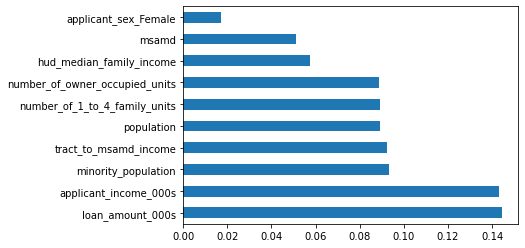

In [17]:
pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh').get_figure().savefig("Resources/importances7f_st.png")